<a href="https://colab.research.google.com/github/RubberLanding/AdversarialMachineLearning24/blob/nico/adversarial_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preliminaries


Install all needed packages.

In [ ]:
!pip install torch
!pip install torchvision
!pip install git+https://github.com/fra31/auto-attack
!pip install statsmodels
# !git pull https://github.com/RubberLanding/AdversarialMachineLearning24

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-s7ey_dpp
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-s7ey_dpp
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done


Download the weights for the pre-trained Resnet18 on CIFAR-10. We only do this once and store them on a private GoogleDrive, which we later import to be able to actually load the weights.

In [6]:
# """Download pre-trained weights for ResNet18 on CIFAR10"""
# !pip install gdown

# # Source: https://github.com/huyvnphan/PyTorch_CIFAR10
# FILE_ID = "17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq"
# file_url = f"https://drive.google.com/uc?id={FILE_ID}"

# !gdown {file_url}

Downloading...
From (original): https://drive.google.com/uc?id=17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq
From (redirected): https://drive.google.com/uc?id=17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq&confirm=t&uuid=dc8031e1-4428-4397-b590-3b159d0d1e09
To: /content/state_dicts.zip
100% 979M/979M [00:08<00:00, 116MB/s]


Import all packages und functions we need.

In [1]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

Mount your GoogleDrive where you stored the weights for the pre-trained Resnet18 before. We will also store the logging files and model weights there.

In [7]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
project_dir = Path('/content/drive/MyDrive/adversarial_training')
project_dir.mkdir(parents=True, exist_ok=True)

import zipfile
import shutil

weight_dir = project_dir / "weights"
weight_dir.mkdir(parents=True, exist_ok=True)
weight_file = weight_dir / "resnet18.pt"

# """Extract the pre-trained model weights to Google Drive"""
# with zipfile.ZipFile("state_dicts.zip", "r") as zip_ref:
#   with zip_ref.open("state_dicts/resnet18.pt") as zf, open(weight_file, 'wb') as f:
#       shutil.copyfileobj(zf, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define a convenience function to name the different training runs.

In [8]:
import random
from datetime import datetime

def generate_run_name():
    """Generate a random name for a run."""
    colors = [
        "red", "blue", "green", "yellow", "purple", "orange", "pink",
        "black", "white", "gray", "silver", "gold", "cyan", "magenta"]
    adjectives = [
        "fast", "slow", "shiny", "dull", "bright", "dark", "silent",
        "loud", "brave", "calm", "wise", "fierce", "kind", "strong"]
    nouns = [
        "dragon", "tiger", "lion", "panda", "wolf", "phoenix", "eagle",
        "fox", "bear", "shark", "hawk", "cheetah", "whale", "octopus"]
    color = random.choice(colors)
    adjective = random.choice(adjectives)
    noun = random.choice(nouns)

    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    run_name = f"{color}-{adjective}-{noun}-{timestamp}"
    return run_name

# Data
Download the CIFAR-10 data. Split it into training, validation and test set. Do some pre-processing.

In [42]:
batch_size = 1024 # batch size has to be < 2**16, should be <= 2**13 for T4
debug = True

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261]),
    ])

""" Load data """
data_train = CIFAR10(root="datasets", train=True, download=True, transform=transform)
data_test = CIFAR10(root="datasets", train=False, download=True, transform=transform)
data_test, data_val = torch.utils.data.random_split(data_test, [0.1, 0.9])

dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=len(data_test), shuffle=False) # create test dataloader with a single batch
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)

num_classes = len(data_train.classes)

# mean = data_train.data.mean(axis=(0,1,2)) / 255 # [0.49139968, 0.48215841, 0.44653091]
# std = data_train.data.std(axis=(0,1,2)) / 255 # [0.24703223, 0.24348513, 0.26158784]

data_train_subset = Subset(data_train, list(range(2*batch_size)))
data_val_subset = Subset(data_val, list(range(10)))
data_test_subset = Subset(data_test, list(range(100)))

dataloader_train_subset = DataLoader(data_train_subset, batch_size=batch_size, shuffle=True)
dataloader_val_subset = DataLoader(data_val_subset, batch_size=len(data_val_subset), shuffle=False)
dataloader_test_subset = DataLoader(data_test_subset, batch_size=len(data_test_subset), shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


# Attacks
Define the attacks.

In [10]:
import torch.nn.functional as F

def fgsm(model, X, y, epsilon=8/255):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=8/255, alpha=2/255, num_iter=10, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def pgd_linf_trades(model, X, y, epsilon=8/255, alpha=2/255, num_iter=10, randomize=False):
    """ Construct FGSM adversarial examples with KL-Divergence for TRADES.
        Should be used together with traded_loss().
    """
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        # maybe set log_target=True and pass F.log_softmax(model(X), dim=1),
        # see the docs for more details
        loss = F.kl_div(F.log_softmax(model(X + delta), dim=1),
                        F.softmax(model(X), dim=1),
                        reduction='batchmean')
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


# Losses
We define a wrapper, that calls the appropriate loss function with the correct arguments. Inside the wrapper, we implement the loss functions.

In [11]:
class LossWrapper:
    def __init__(self, loss_fn, lambda_tradeoff=1.0):
        self.loss_fn = loss_fn
        self.lambda_tradeoff = lambda_tradeoff

    def __call__(self, model, X, y, delta=0.0):
        """Args:
              model: The model being trained.
              X: Clean input data.
              delta: Perturbations applied to X.
              y: Ground-truth labels.
        """
        # Cross-Entropy Loss
        if self.loss_fn == "CE":
            yp = model(X + delta)
            return F.cross_entropy(yp, y)

        # TRADES Loss
        elif self.loss_fn == "TRADES":
            yp_adv = model(X + delta)
            yp_clean = model(X)
            clean_loss = F.cross_entropy(yp_clean, y)
            robust_loss = F.kl_div(F.log_softmax(yp_adv, dim=1),
                            F.softmax(yp_clean, dim=1),
                            reduction='batchmean')
            return clean_loss + self.lambda_tradeoff * robust_loss

        else:
            raise ValueError("Unsupported loss function")

# Training

Define functions that train a model.

In [12]:
def train_epoch(loader, model, opt, loss_fn):
    """Standard training/evaluation epoch over the dataset"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = loss_fn(model, X, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(loader, model, loss_fn):
    """Standard training/evaluation epoch over the dataset"""
    model.eval()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = loss_fn(model, X, y)
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def train_epoch_adversarial(loader, model, attack, opt, loss_fn, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = loss_fn(model, X, y, delta)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def eval_epoch_adversarial(loader, model, attack, loss_fn, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    model.eval()  # Set the model to evaluation mode
    total_loss, total_err = 0.0, 0.0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        # Compute adversarial perturbations (requires gradients)
        with torch.enable_grad():
            delta = attack(model, X, y, **kwargs)

        # Evaluate the model on adversarial examples without gradients
        with torch.no_grad():
            yp = model(X + delta)
            loss = loss_fn(model, X, y, delta)

            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def train_epoch_rs(loader, model, opt, loss_fn, sigma=0.25):
    """Training epoch with Gaussian noise over the dataset for Randomized Smoothing"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X + torch.randn_like(X) * sigma) # Add Gaussian noise
        loss = loss_fn(model, X, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch_rs(loader, model, loss_fn, sigma=0.25):
    """Standard training/evaluation epoch over the dataset"""
    model.eval()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X + torch.randn_like(X) * sigma)
        loss = loss_fn(model, X, y)
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Models

## Setup the Advarsarial Training Model


In [ ]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

model_adv = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_adv.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_adv.fc = torch.nn.Linear(model_adv.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_adv.load_state_dict(pretrained_weights)
model_adv = model_adv.to(device)

###########################
# SET LOGGING

run_dir = project_dir / generate_run_name()
run_dir.mkdir(parents=True, exist_ok=True)
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}


## Train the Adversarial Training Model
Use adversarial training to train the robust model.

In [ ]:
###########################
# SET TRAINING PARAMETERS

opt = Adam(model_adv.parameters(), lr=1e-3)
# opt = SGD(model_adv.parameters(), lr=1e-1)
# scheduler = CosineAnnealingLR(opt, T_max=100)
# scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=0)

epochs = 15

trades = LossWrapper("TRADES")
cross_entropy = LossWrapper("CE")
###########################
# START TRAINING

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "Epoch   "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch_adversarial(dataloader_train_subset, model_adv, pgd_linf_trades, opt, loss_fn=trades)
    test_err, test_loss = eval_epoch(dataloader_val_subset, model_adv, loss_fn=cross_entropy)
    adv_err, adv_loss = eval_epoch_adversarial(dataloader_val_subset, model_adv, fgsm, loss_fn=cross_entropy)

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["adv_losses"] += [adv_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]
    log["adv_errors"] += [adv_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            "{:.6f}".format(adv_err),
            f"{t+1}",), sep="\t")

###########################
# STORE RESULTS
store = False # set this variable to True when you have runs that you want to save
if store:
  with open(run_dir / "log.json", "w") as f:
      json.dump(log, f)
  torch.save(model_adv.state_dict(), run_dir / "model_adv.pt")

Begin adversarial training run: orange-fierce-shark-20250110-1652

TR      	TE      	ADV     	Epoch   
0.626953	0.881836	0.900391	1
0.663086	0.654297	0.766602	2
0.527832	0.529297	0.693359	3
0.488281	0.471680	0.630859	4
0.428223	0.421875	0.595703	5
0.390625	0.392578	0.596680	6
0.351074	0.377930	0.587891	7
0.308105	0.366211	0.580078	8
0.262695	0.351562	0.568359	9
0.233887	0.329102	0.559570	10
0.197266	0.332031	0.552734	11
0.170898	0.321289	0.539062	12
0.141113	0.310547	0.532227	13
0.111328	0.318359	0.533203	14
0.080566	0.323242	0.543945	15


Install AutoAttack to calculate a robust accuracy for the model to get a fair comparison, e.g. with models from [RobustBench](https://robustbench.github.io/).

In [ ]:
!pip install git+https://github.com/fra31/auto-attack

In [ ]:
from autoattack import AutoAttack

X, y = next(iter(dataloader_test)) # optimally, the test loader has a single batch containing the entire test set
X, y = X.to(device), y.to(device)

adversary = AutoAttack(model_adv, norm='Linf', eps=8/255, version='standard')
adv_examples = adversary.run_standard_evaluation(X, y, bs=batch_size) # this takes ~8min on T4 on a single test batch

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 58.30%
apgd-ce - 1/5 - 35 out of 128 successfully perturbed
apgd-ce - 2/5 - 29 out of 128 successfully perturbed
apgd-ce - 3/5 - 32 out of 128 successfully perturbed
apgd-ce - 4/5 - 31 out of 128 successfully perturbed
apgd-ce - 5/5 - 23 out of 71 successfully perturbed
robust accuracy after APGD-CE: 43.30% (total time 16.5 s)
apgd-t - 1/4 - 17 out of 128 successfully perturbed
apgd-t - 2/4 - 14 out of 128 successfully perturbed
apgd-t - 3/4 - 16 out of 128 successfully perturbed
apgd-t - 4/4 - 7 out of 49 successfully perturbed
robust accuracy after APGD-T: 37.90% (total time 122.8 s)
fab-t - 1/3 - 3 out of 128 successfully perturbed
fab-t - 2/3 - 2 out of 128 successfully perturbed
fab-t - 3/3 - 2 out of 123 successfully perturbed
robust accuracy after FAB-T: 37.20% (total time 285.0 s)
square - 1/3 - 1 out of 128 successfully perturbed
square - 2/3 - 1 out of 12

## Setup the Weight Averaging Model
Here we initialize an exponential moving average (EMA) model, based on the robust model.

In [ ]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

model_adv = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_adv.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_adv.fc = torch.nn.Linear(model_adv.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_adv.load_state_dict(pretrained_weights)

model_ema = torch.optim.swa_utils.AveragedModel(model_adv, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9))

model_adv = model_adv.to(device)
model_ema = model_ema.to(device)

###########################
# SET LOGGING

run_dir = project_dir / generate_run_name()
run_dir.mkdir(parents=True, exist_ok=True)
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}


# Train the Weight Averaged Model

In [ ]:
###########################
# SET TRAINING PARAMETERS

opt = Adam(model_adv.parameters(), lr=1e-3)
# opt = SGD(model_adv.parameters(), lr=1e-1)
# scheduler = CosineAnnealingLR(opt, T_max=100)
# scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=0)

epochs = 15

trades = LossWrapper("TRADES")
cross_entropy = LossWrapper("CE")

###########################
# START TRAINING

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "Epoch   "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch_adversarial(dataloader_train_subset, model_adv, pgd_linf, opt, loss_fn=cross_entropy)
    model_ema.update_parameters(model_adv) # Update EMA model

    test_err, test_loss = eval_epoch(dataloader_val_subset, model_ema, loss_fn=cross_entropy) # Evaluate clean acc. on EMA model
    adv_err, adv_loss = eval_epoch_adversarial(dataloader_val_subset, model_ema, fgsm, loss_fn=cross_entropy) # Evaluate robust acc. on EMA model

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["adv_losses"] += [adv_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]
    log["adv_errors"] += [adv_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            "{:.6f}".format(adv_err),
            f"{t+1}",), sep="\t")

###########################
# STORE RESULTS
store = False # set this variable to True when you have runs that you want to save
if store:
  with open(run_dir / "log.json", "w") as f:
      json.dump(log, f)
  torch.save(model_adv.state_dict(), run_dir / "model_adv.pt")
  torch.save(model_ema.state_dict(), run_dir / "model_ema.pt")

Begin adversarial training run: gray-loud-fox-20250110-1808

TR      	TE      	ADV     	Epoch   
0.732910	0.805664	0.852539	1
0.758301	0.713867	0.785156	2
0.650391	0.889648	0.894531	3
0.620605	0.897461	0.898438	4
0.579102	0.893555	0.895508	5
0.544922	0.886719	0.890625	6
0.514648	0.884766	0.887695	7
0.481934	0.871094	0.879883	8
0.457031	0.828125	0.862305	9
0.412598	0.760742	0.809570	10
0.385742	0.684570	0.737305	11
0.358398	0.646484	0.712891	12
0.323730	0.648438	0.708008	13
0.275879	0.602539	0.669922	14
0.239746	0.542969	0.632812	15


# Randomized Smoothing

In [35]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm, binomtest

class RandomizedSmoother(object):

  def __init__(self, base_model, num_classes, sigma=0.25, epsilon=8/255, alpha=0.05, norm="L2"):
    self.base_model = base_model
    self.num_classes = num_classes
    self.sigma = sigma
    self.epsilon = epsilon
    self.norm = norm
    self.alpha = alpha

  def predict(self, X, num_samples=100):
    batch_size = X.size(0)
    # Compute class counts for noisy samples
    class_counts = self.get_noisy_counts(X, num_samples)

    # Sort class counts to find top 2 most frequent classes
    sorted_counts_vals, sorted_counts_ind = class_counts.sort()
    top1_class = sorted_counts_ind[:, -1]  # Most frequent class
    top2_class = sorted_counts_ind[:, -2]  # Second most frequent class
    top1_class_count = sorted_counts_vals[:, -1]
    top2_class_count = sorted_counts_vals[:, -2]

    predictions = torch.zeros(batch_size, device=X.device)
    for i in range(batch_size):
        # Use binomial test to check if the top class is significantly more frequent
        n_a, n_b = top1_class_count[i], top2_class_count[i]
        predictions[i] = top1_class[i] if binomtest(n_a, n_a + n_b, p=0.5).pvalue <= self.alpha else float('nan')

    return predictions

  def certify(self, X, num_samples_selection=100, num_samples_estimation=100):
    batch_size = X.size(0)
    # Perform two sampling procedures to avoid selection bias
    counts_a = self.get_noisy_counts(X, num_samples_selection)
    top1_class = counts_a.argmax(dim=-1).unsqueeze(1)  # Get most frequent class index

    counts = self.get_noisy_counts(X, num_samples_estimation)
    # Extract the counts for the most frequent class
    n_a = counts.gather(dim=1, index=top1_class).squeeze()

    certified_radii = torch.zeros(batch_size)
    predictions = torch.zeros(batch_size, device=X.device)
    for i in range(batch_size):
        # Compute lower confidence bound for the top class probability
        conf_bound, _ = proportion_confint(n_a[i], num_samples_estimation, alpha=2 * self.alpha, method="beta")
        # Calculate the certified radius based on the confidence bound
        if conf_bound >= 0.5:
          certified_radii[i] = self.get_radius(conf_bound, self.norm)
          predictions[i] = top1_class[i]
        else:
          certified_radii[i] = float("nan")
          predictions[i] = float("nan")

    return certified_radii, predictions

  def get_noisy_counts(self, X, num_samples):
    batch_size = X.size(0)
    class_counts = torch.zeros(batch_size, self.num_classes, dtype=torch.int64, device=X.device)

    for _ in range(num_samples):
        # Generate noisy samples based on the specified norm
        noisy_samples = X + self.get_noise(X.shape, self.norm)
        with torch.no_grad():
            # Predict classes for noisy samples
            logits = self.base_model(noisy_samples)
            class_pred = F.softmax(logits, dim=-1).argmax(dim=-1)
            # Update class counts
            for i in range(batch_size):
                class_counts[i, class_pred[i]] += 1

    return class_counts

  def get_noise(self, shape, p_norm="L2"):
    if p_norm=="L2":
      return torch.randn(shape) * self.sigma
    elif p_norm=="Linf":
      return 2 * self.epsilon * torch.rand(shape) - self.epsilon
    else:
      raise ValueError("Unsupported norm.")

  def get_radius(self, conf_bound, p_norm="L2"):
    if p_norm=="L2":
      return self.sigma * norm.ppf(conf_bound)
    elif p_norm=="Linf":
      return self.epsilon * (2 * conf_bound - 1)
    else:
      raise ValueError("Unsupported norm.")


In [16]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

model_base = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_base.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_base.fc = torch.nn.Linear(model_base.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_base.load_state_dict(pretrained_weights)
model_base = model_base.to(device)

###########################
# SET LOGGING

run_dir = project_dir / generate_run_name()
run_dir.mkdir(parents=True, exist_ok=True)
log = {key: [] for key in ["train_losses", "test_losses",
                           "train_errors", "test_errors"]}


In [ ]:
###########################
# SET TRAINING PARAMETERS

opt = Adam(model_adv.parameters(), lr=1e-3)
# opt = SGD(model_adv.parameters(), lr=1e-1)

epochs = 15
cross_entropy = LossWrapper("CE")
sigma=0.25

###########################
# START TRAINING

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "Epoch   "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch_rs(dataloader_train_subset, model_base, opt, cross_entropy, sigma)
    test_err, test_loss = eval_epoch_rs(dataloader_val_subset, model_base, cross_entropy, sigma)

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            f"{t+1}",), sep="\t")

###########################
# STORE RESULTS
store = False # set this variable to True when you have runs that you want to save
if store:
  with open(run_dir / "log.json", "w") as f:
      json.dump(log, f)
  torch.save(model_base.state_dict(), run_dir / "model_base.pt")


In [60]:
num_samples_estimation = 200
num_samples_selection = 100

sigma = 0.25
alpha = 0.05
epsilon = 8/255

sigmas = [0.1]
log_rs = {f"sigma={sigma}": [[],[]] for sigma in sigmas}

X, y = next(iter(dataloader_val_subset))
X, y = X.to(device), y.to(device)

for sigma in sigmas:
  model_rs = RandomizedSmoother(model_base, num_classes, sigma, epsilon, alpha)
  log_rs[f"sigma={sigma}"] = model_rs.certify(X, num_samples_selection, num_samples_estimation)


{'sigma=0.1': (tensor([0.2174, 0.2174, 0.2174, 0.2174, 0.2174, 0.1986, 0.2174, 0.2174, 0.2174,
          0.0810]),
  tensor([7., 1., 2., 4., 8., 1., 6., 3., 9., 4.]))}

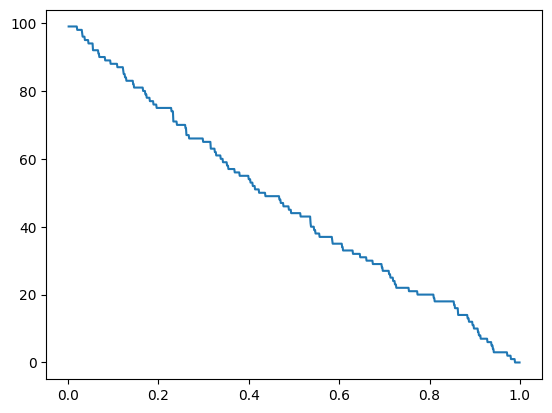

In [107]:
np.set_printoptions(threshold=100)
radius = torch.rand(1000)
yp = torch.randint(0, 10, size=(1000,))
y = torch.randint(0, 10, size=(1000,))

def discretize(radius, yp, y, num_bins=1000):
  min_val, max_val = radius.min(), radius.max()
  bin_edges = torch.linspace(min_val, max_val, num_bins + 1)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Use bin centers for comparisons
  counts = np.array([(yp[radius > bin_value] == y[radius > bin_value]).sum() for bin_value in bin_centers])
  return bin_centers, counts

x, y = discretize(radius, yp, y)

import matplotlib.pyplot as plt

plt.plot(x,y)

In [91]:
(yp == y).sum()

tensor(103)

In [104]:
min_val, max_val = radius.min(), radius.max()
bin_edges = torch.linspace(min_val, max_val, 1000 + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Use bin centers for comparisons
# counts = np.array([(radius > bin_value).sum() for bin_value in bin_centers])
bin_centers[:100]
bin_edges[:100]

tensor([0.0001, 0.0011, 0.0021, 0.0031, 0.0041, 0.0051, 0.0061, 0.0071, 0.0081,
        0.0091, 0.0101, 0.0111, 0.0121, 0.0131, 0.0141, 0.0151, 0.0161, 0.0171,
        0.0181, 0.0191, 0.0201, 0.0211, 0.0221, 0.0231, 0.0241, 0.0251, 0.0261,
        0.0271, 0.0281, 0.0291, 0.0301, 0.0311, 0.0321, 0.0331, 0.0341, 0.0351,
        0.0361, 0.0371, 0.0381, 0.0391, 0.0401, 0.0411, 0.0421, 0.0431, 0.0441,
        0.0451, 0.0461, 0.0471, 0.0481, 0.0491, 0.0501, 0.0511, 0.0521, 0.0531,
        0.0541, 0.0551, 0.0561, 0.0571, 0.0581, 0.0591, 0.0601, 0.0611, 0.0621,
        0.0631, 0.0641, 0.0651, 0.0661, 0.0671, 0.0681, 0.0691, 0.0701, 0.0711,
        0.0721, 0.0731, 0.0741, 0.0751, 0.0761, 0.0771, 0.0781, 0.0791, 0.0801,
        0.0811, 0.0821, 0.0831, 0.0841, 0.0851, 0.0861, 0.0871, 0.0881, 0.0891,
        0.0901, 0.0911, 0.0921, 0.0931, 0.0941, 0.0951, 0.0961, 0.0971, 0.0981,
        0.0991])

# Regular Training

In [ ]:
""" Regular Training """
import json
from torch.nn import CrossEntropyLoss, Conv2d

model_reg = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_reg.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_reg.fc = torch.nn.Linear(model_reg.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_reg.load_state_dict(pretrained_weights)
model_reg = model_reg.to(device)

run_dir = project_dir / generate_run_name()
run_dir.mkdir(parents=True, exist_ok=True)

opt = SGD(model_reg.parameters(), lr=1e-1)
opt = Adam(model_reg.parameters(), lr=1e-3)

epochs = 2
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "     "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch(dataloader_train, model_reg, opt)
    test_err, test_loss = eval_epoch(dataloader_test, model_reg)
    adv_err, adv_loss = eval_epoch_adversarial(dataloader_test, model_reg, fgsm)

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["adv_losses"] += [adv_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]
    log["adv_errors"] += [adv_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            "{:.6f}".format(adv_err),
            f"Epoch: {t+1}",), sep="\t")

with open(run_dir / "log.json", "w") as f:
    json.dump(log, f)
torch.save(model_reg.state_dict(), run_dir / "model_reg.pt")

In [ ]:
"""
ADV evaluated with FGSM
We observe that the ADV validation error is lower than the training error because FGSM is a weaker attack thatn PGD
Begin adversarial training run: magenta-slow-phoenix-20250105-1507

TR      	TE      	ADV     	Epoch
0.666760	0.406778	0.493000	1
0.539120	0.314444	0.405000	2
0.476300	0.274778	0.379000	3
0.432680	0.245222	0.339556	4
0.402620	0.230444	0.330000	5

ADV evaluated with PGD-Linf
We observe that the ADV validation error is higher than the training error as expected
Begin adversarial training run: orange-kind-shark-20250105-1531

TR      	TE      	ADV     	Epoch
0.675220	0.419667	0.599000	1
0.543500	0.310889	0.508778	2
0.472780	0.271000	0.475556	3
0.434380	0.248000	0.461889	4
0.403640	0.230444	0.457889	5
"""

In [ ]:
"""
gold-bright-eagle-20241204-1128:
SGD(lr=1e-1), batch_size=1024
"""
"""
orange-kind-hawk-20241204-1148:
SGD(lr=1e-1, weight_decay=5e-4), batch_size=1024
"""
"""
silver-shiny-phoenix-20241204-1210:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024
"""
"""
gray-fierce-octopus-20241204-1226:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024, CosineAnnealingLR
"""
"""
gold-loud-cheetah-20241204-1414:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024,, epsilon=4/255
"""
"""
cyan-wise-eagle-20241203-1710:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024,, epsilon=32/255
"""